In [1]:
# default_exp image

This contains the `Img` class, which encapsulates how to read/load images. Image arrays are expected to be scaled between [0,1] and be floats.

# Import

In [2]:
# export
import warnings

import numpy as np
from PIL import Image

from camera_calib_python.utils import *

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt

# Utility

In [4]:
# export
def rgb2gray(arr): # From Pillow documentation
    return arr[:,:,0]*(299/1000) + arr[:,:,1]*(587/1000) + arr[:,:,2]*(114/1000)

# Base class

In [5]:
# export
class Img:    
    def exists(self): raise NotImplementedError('Please implement exists()')
        
    @property
    def name(self):   raise NotImplementedError('Please implement name')
    @property
    def size(self):   raise NotImplementedError('Please implement size')
    @property
    def array(self):  raise NotImplementedError('Please implement array')
    @property
    def array_gs(self): # gs == "gray scale"
        arr = self.array
        if len(arr.shape) == 3 and arr.shape[2] == 3:
            arr = rgb2gray(arr)
        elif len(arr.shape) == 2:
            pass
        else:
            raise RuntimeError(f'Dont know how to handle array of shape: {arr.shape}')
        return arr
    
    def __repr__(self):
        return f'{self.__class__.__name__}({self.name})'

Note that `size` is the 2D shape

# File Image

In [6]:
# export
class FileImg(Img):
    def __init__(self, file_img):
        self.file_img = file_img
    
    def exists(self): return self.file_img.exists()

    @property
    def name(self):   return self.file_img.stem
    @property
    def size(self):   return reverse(Image.open(self.file_img).size) # fast

For some reason the 16 bit images I've got get read as 32bit signed integers, and I found it hard to write a generic `FileImg` class that can scale values to [0,1] correctly. So just subclass it for now.

In [7]:
# export
class File16bitImg(FileImg):
    def __init__(self, file_img):
        super().__init__(file_img)
        
    @property
    def array(self):
        arr = np.array(Image.open(self.file_img), dtype=np.float)
        arr /= 2**16-1 # Scale between 0 and 1 for 16 bit image
        return arr

Test out methods

In [8]:
file_img1 = Path('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1.png')
file_img2 = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')

In [9]:
img1, img2 = map(File16bitImg, [file_img1, file_img2])

In [10]:
assert_allclose(img1.array_gs.min(), 0.0029297322041657)
assert_allclose(img1.array_gs.max(), 0.9995269703212024)
assert_allclose(img1.name, 'SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1')
assert_allclose(img1.size, (1536, 2048))
assert_allclose(img1.exists(), True)

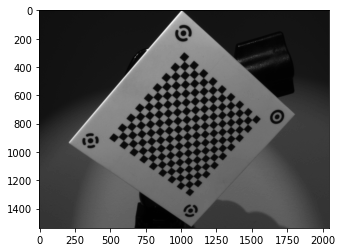

In [11]:
plt.imshow(img1.array_gs, cmap='gray')

# Array Image

This could be useful if there's an image in memory and you don't want to save it. Note that it is the responsbility of the user to ensure values are scaled from 0 to 1.

In [12]:
# export
class ArrayImg(Img):
    def __init__(self, arr, name=None):
        if len(arr.shape) < 2: raise RuntimeError('Input array has less than 2 dimensions')
        self.sz = arr.shape[:2]
        self.n = name        
        
        assert_allclose(arr.dtype, np.float)
        if arr.min() < 0: warnings.warn('Value less than 0 found')    
        if arr.max() > 1: warnings.warn('Value greater than 1 found')    
        self.arr = arr
        
    @property
    def name(self):   return self.n
    @property
    def size(self):   return self.sz
    @property
    def array(self):  return self.arr

    def exists(self): return True

In [13]:
array1, array2 = [np.clip(np.random.normal(size=(20,10,3)), 0, 1) for _ in range(2)]
img1, img2 = [ArrayImg(arr, f'array{i+1}') for i, arr in enumerate([array1, array2])]

In [14]:
assert_allclose(img1.array_gs.min(), rgb2gray(array1).min())
assert_allclose(img1.array_gs.max(), rgb2gray(array1).max())
assert_allclose(img1.name, 'array1')
assert_allclose(img1.size, array1.shape[:2])
assert_allclose(img1.exists(), True)

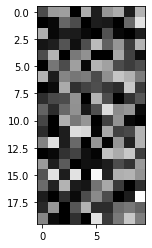

In [15]:
plt.imshow(img1.array_gs, cmap='gray')

# Build

In [16]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [17]:
!nbdev_build_lib

Converted README.ipynb.
Converted calib.ipynb.
Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted plot.ipynb.
Converted utils.ipynb.
